In [1]:
import fedhex as fx
from matplotlib import pyplot as plt
import numpy as np

2023-08-27 13:58:32.945063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13:58:36.02 <W> --- ./root/10x10box_10k_jun2023//Phi_1870_omega_9p025/2023-06-
12-11-54-06/v1p0-78-8cf4/ATTOAODv1p2c2_0.root: empty file ---


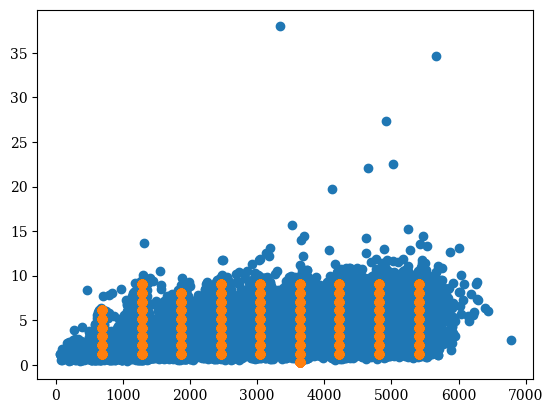

In [2]:
root_path = "./root/10x10box_10k_jun2023/"
rl = fx.RootLoader(root_path)
s, l = rl.load(event_thresh=100)
data, cond = rl.preproc()
plt.scatter(s[:,0], s[:,1])
plt.scatter(l[:,0], l[:,1])
pass

In [3]:
data_dir = "./data/08-26_tut/"
config_path = data_dir + "tut.json"
if rl.save(config_path=config_path):
    print("Successful save")
else:
    print("Failure to save")


13:58:58.33 <D> Removing data stored at './data/08-26_tut/tut.json'

Successful save


In [4]:
export_path = data_dir + "tut.npy"
rl.save_to_npy(export_path)

In [5]:
d = np.load(export_path, allow_pickle=True).item()
d

{'data': array([[-2.02072326, -1.91331206],
        [-1.94896113, -1.80833915],
        [-2.00833956, -2.45690174],
        ...,
        [ 1.73379193,  1.02653691],
        [ 1.57835952,  1.38800619],
        [ 1.61040194,  1.44329077]]),
 'cond': array([[-2.73474407, -0.79168081],
        [-2.73474407, -0.79168081],
        [-2.73474407, -0.79168081],
        ...,
        [ 2.39604442,  2.99578623],
        [ 2.39604442,  2.99578623],
        [ 2.39604442,  2.99578623]]),
 'whiten_data': {'min': array([66.57292701,  0.4403476 ]),
  'max': array([6778.68409203,   37.97291039]),
  'mean': array([-0.30603196, -2.40196571]),
  'std': array([1.03115838, 0.84500649]),
  'epsilon': 1e-05},
 'whiten_cond': {'min': array([6.8999999e+02, 2.4999000e-01]),
  'max': array([5408.00001,    9.03126]),
  'mean': array([1.31841954, 1.21665624]),
  'std': array([7.78518381, 4.16214248]),
  'epsilon': 1e-05}}

In [6]:
ld1 = fx.Loader(export_path)

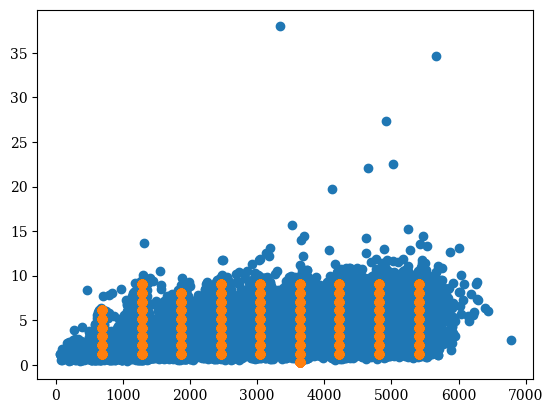

In [7]:
s1, l1 = ld1.load()
plt.scatter(s1[:,0], s1[:,1])
plt.scatter(l1[:,0], l1[:,1])
pass

In [8]:
ld2 = fx.Loader(data_dict=d)

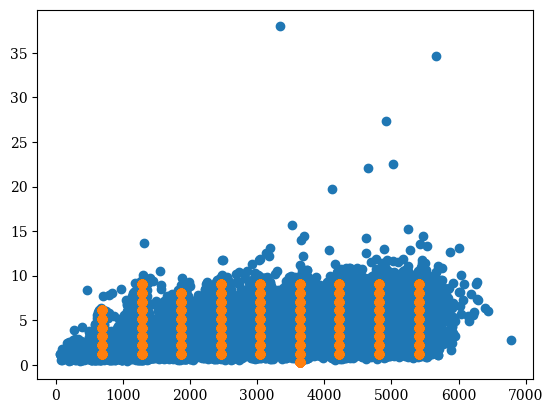

In [9]:
s2, l2 = ld2.load()
plt.scatter(s2[:,0], s2[:,1])
plt.scatter(l2[:,0], l2[:,1])
pass

In [10]:
mm = fx.MADEManager(nmade=5, ninputs=2, ncinputs=2, hidden_layers=1,
                    hidden_units=128, lr_tuple=(1e-3, 1e-4, 100))
mm.compile_model()

In [11]:
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger

flow_path = "./model/08-26_tut/"
loss_path = flow_path + "loss.npy"
batch_size = 1024
save_freq = 50 * batch_size
end_epoch = 100
callbacks = []
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))
callbacks.append(EpochLossHistory(loss_path=loss_path))
callbacks.append(SelectiveProgbarLogger(verbose=1, epoch_interval=10, epoch_end=end_epoch))

In [12]:
mm.train_model(data, cond, batch_size=batch_size, starting_epoch=0,
               end_epoch=end_epoch, path=flow_path, callbacks=callbacks)

13:59:01.80 <I> [Training begins]
epoch begin: 2023-08-27 13:59:12.394619 | time elapsed: 0:00:10.482558
Epoch 10/100
47/47 [==============================] - 1s 13ms/sample - loss: 1.7019
epoch begin: 2023-08-27 13:59:17.428341 | time elapsed: 0:00:15.516280
Epoch 20/100
47/47 [==============================] - 1s 12ms/sample - loss: 1.0107
epoch begin: 2023-08-27 13:59:23.229367 | time elapsed: 0:00:21.317306
Epoch 30/100
47/47 [==============================] - 1s 14ms/sample - loss: 0.5328
epoch begin: 2023-08-27 13:59:28.434829 | time elapsed: 0:00:26.522768
Epoch 40/100
47/47 [==============================] - 1s 13ms/sample - loss: 0.2872
epoch begin: 2023-08-27 13:59:34.079120 | time elapsed: 0:00:32.167059
Epoch 50/100
47/47 [==============================] - 1s 13ms/sample - loss: 0.1443
epoch begin: 2023-08-27 13:59:39.510886 | time elapsed: 0:00:37.598825
Epoch 60/100
47/47 [==============================] - 1s 15ms/sample - loss: 0.0371
epoch begin: 2023-08-27 13:59:44.910

INFO:tensorflow:Assets written to: ./model/08-26_tut/assets


INFO:tensorflow:Assets written to: ./model/08-26_tut/assets


14:00:11.44 <I> [Training ends]
0:01:09.64 <I> [Time elapsed]


In [13]:
ngen = 500
gen_label_unique = np.array([2464., 5.125])
gen_labels = np.repeat([gen_label_unique], ngen, axis=0)
gen_cond = rl.norm(gen_labels, is_cond=True)
gen_data = mm.eval_model(gen_cond)
gen_samples = rl.denorm(gen_data)

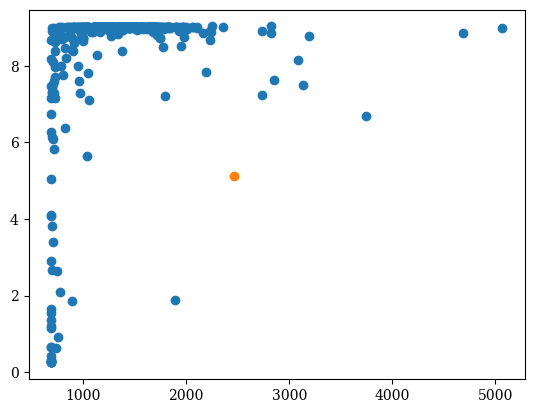

In [14]:
plt.scatter(gen_samples[:,0], gen_samples[:,1])
plt.scatter(gen_label_unique[0], gen_label_unique[1])
pass

In [15]:
model_config_path = flow_path + "tut.json"
mm.save(model_config_path)


14:00:15.45 <D> Removing data stored at './model/08-26_tut/tut.json'



True

In [16]:
model_path = flow_path + "save_tut/"
mm.export_model(model_path)

INFO:tensorflow:Assets written to: ./model/08-26_tut/save_tut/assets


INFO:tensorflow:Assets written to: ./model/08-26_tut/save_tut/assets


True